In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

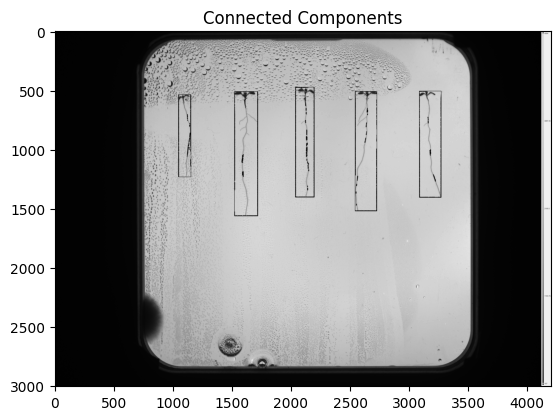

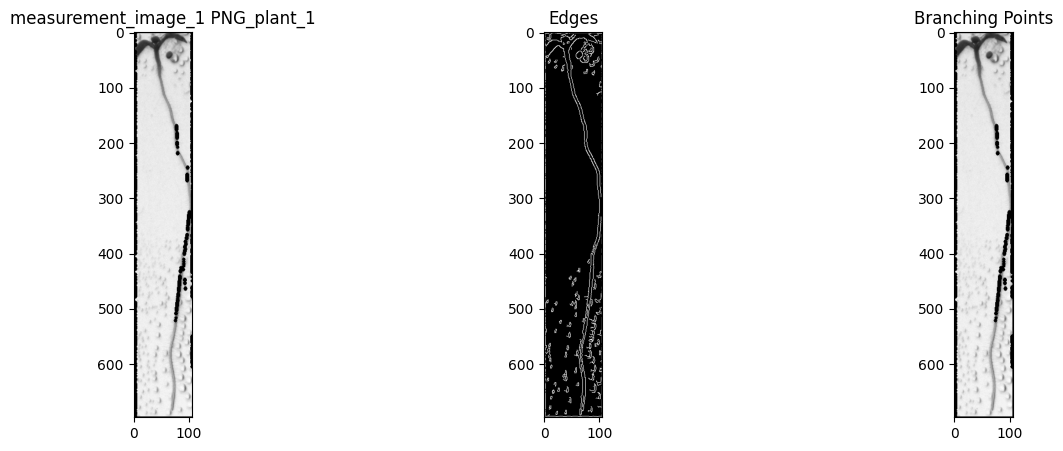

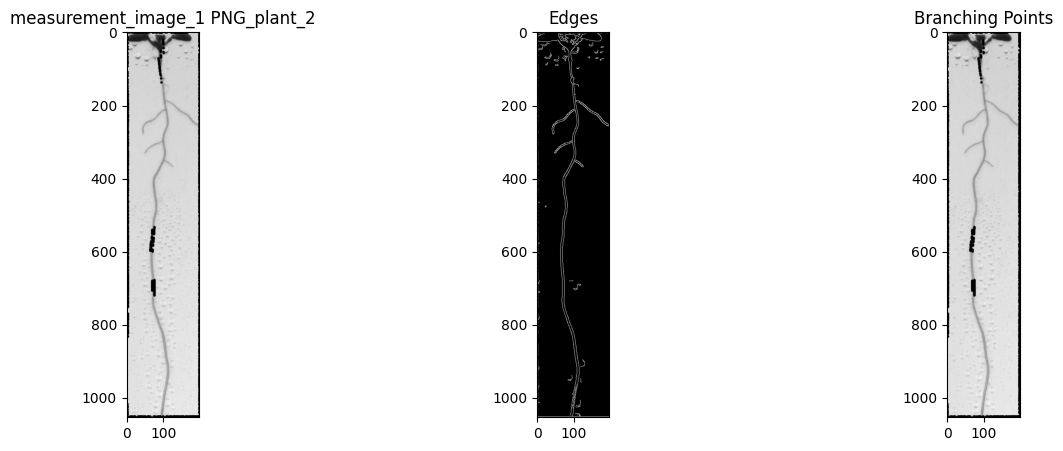

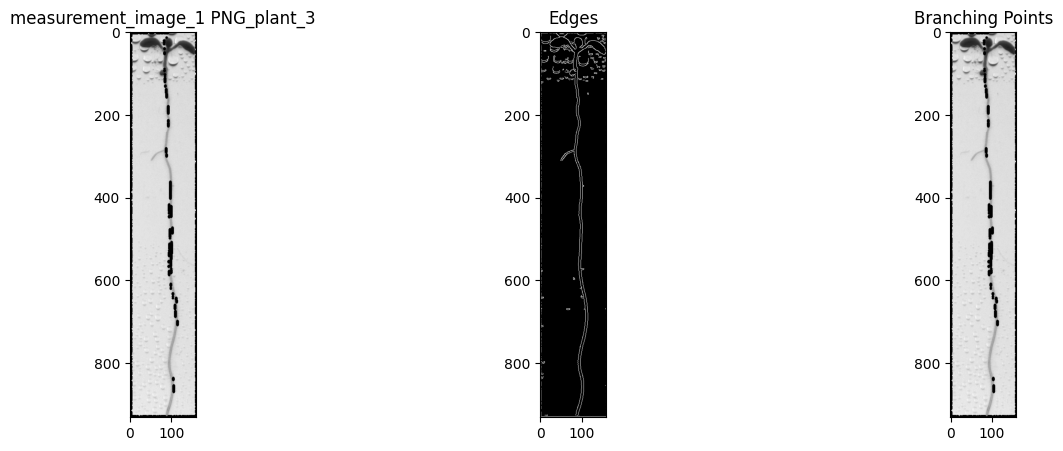

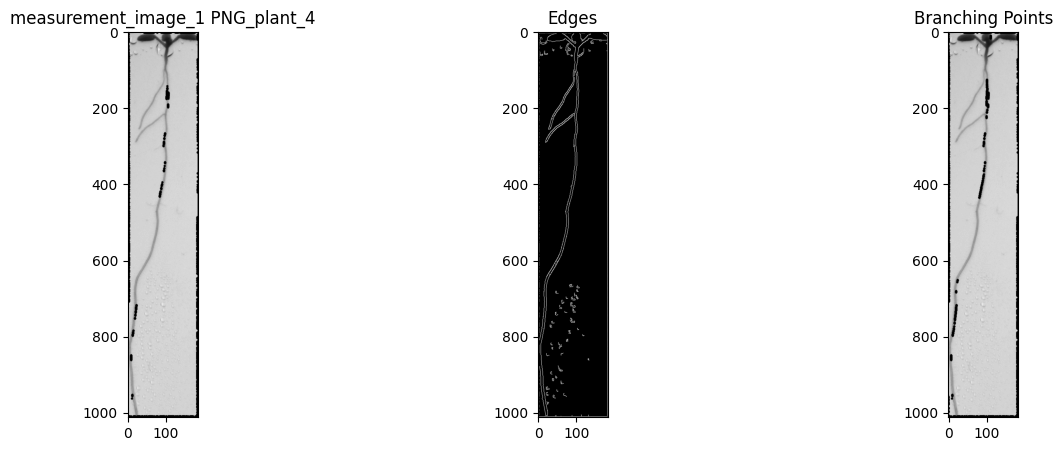

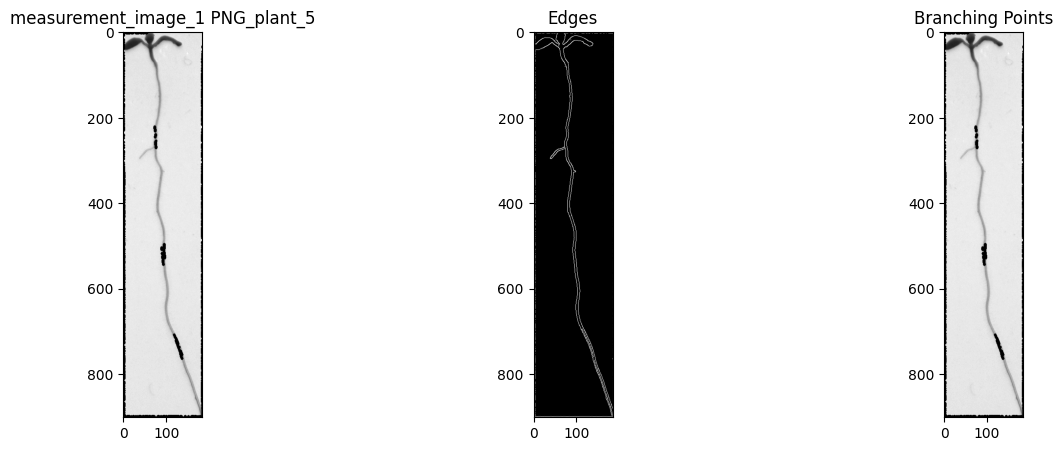

In [2]:

def process_image_with_cropping(image_path):
    # Read image
    im = cv2.imread(image_path, 0)
    if im is None:
        raise ValueError("Unable to read the image at path:", image_path)

    # Crop image
    original_im = im.copy()
    im = im [250:2000, 900:3500]

    # Apply Gaussian Blur
    im_blur = cv2.GaussianBlur(im, (5, 5), 0)

    # Apply Adaptive Threshold
    output_im = cv2.adaptiveThreshold(im_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 2)

    # Morphological operations
    kernel = np.ones((3, 3), np.uint8)
    output_im = cv2.erode(output_im, kernel, iterations=1)
    output_im = cv2.dilate(output_im, kernel, iterations=1)

    contours, _ = cv2.findContours(output_im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_contour_area = 2000
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < min_contour_area:
            cv2.drawContours(output_im, [contour], 0, 0, -1)

    closing_kernel = np.ones((5, 5), np.uint8)
    output_im = cv2.morphologyEx(output_im, cv2.MORPH_CLOSE, closing_kernel)

    large_closing_kernel = np.ones((15, 15), np.uint8)
    output_im = cv2.morphologyEx(output_im, cv2.MORPH_CLOSE, large_closing_kernel)

    # Connected components
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # Sort bounding boxes
    sorted_stats = sorted(stats[1:], key=lambda x: x[0])

    length_im = []
    cropped_images = []

    for i, stat in enumerate(sorted_stats, start=1):
        x, y, w, h, area = stat

        # Bounding box
        cv2.rectangle(original_im, (x + 900, y + 250), (x + w + 900, y + h + 250), (0, 255, 0), 2)

        # Crop image around bounding box
        cropped = original_im[y + 250:y + h + 250, x + 900:x + w + 900]

        # Apply edge detection to cropped image
        cropped_edges = cv2.Canny(cropped, 50, 150)

        # Apply skeletonization
        skeleton = skeletonize(cropped_edges)

        # Find branching points using point detection algorithm
        branching_points = find_branching_points(skeleton)

        # Draw circles at branching points
        for point in branching_points:
            cv2.circle(cropped, point, 3, (0, 255, 0), -1)

        # Add cropped image with edges and branching points to the list
        cropped_images.append((cropped, cropped_edges))

        length = abs(x + h - x)
        length_im.append(length)

    # Prepare measurements
    plants_names = ['{}_plant_{}'.format(image_path.split('/')[-1].split('.')[0], i+1) for i in range(len(length_im))]
    measurements = length_im

    return original_im, plants_names, measurements, cropped_images

def skeletonize(image):
    size = np.size(image)
    skel = np.zeros(image.shape, np.uint8)

    ret, image = cv2.threshold(image, 127, 255, 0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        eroded = cv2.erode(image, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(image, temp)
        skel = cv2.bitwise_or(skel, temp)
        image = eroded.copy()

        zeros = size - cv2.countNonZero(image)
        if zeros == size:
            done = True

    return skel

def find_branching_points(skeleton):
    # Use the Hough transform to detect lines in the skeletonized image
    lines = cv2.HoughLinesP(skeleton, 1, np.pi / 180, threshold=100, minLineLength=10, maxLineGap=10)

    # Convert lines to a binary image
    lines_image = np.zeros_like(skeleton)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lines_image, (x1, y1), (x2, y2), 255, 1)

    # Find junctions by detecting intersections in the binary image
    junctions = []
    intersections = cv2.bitwise_and(skeleton, lines_image)
    points = cv2.findNonZero(intersections)
    if points is not None:
        for point in points:
            junctions.append((point[0][0], point[0][1]))

    return junctions

# Example usage:
image_path = "C:/Users/thoma/Desktop/University/Year 2/Block D/2023-24d-fai2-adsai-ThomasPichardo223834/Pipeline testin/Images/PNG/measurement_image_1 PNG.png"
try:
    processed_image, plants_names, measurements, cropped_images = process_image_with_cropping(image_path)
    # Display results
    plt.imshow(processed_image, cmap='gray')
    plt.title('Connected Components')
    plt.show()

    # Display cropped images with edges and branching points
    for i, (cropped_image, cropped_edges) in enumerate(cropped_images):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(cropped_image, cmap='gray')
        axes[0].set_title(plants_names[i])
        axes[1].imshow(cropped_edges, cmap='gray')
        axes[1].set_title("Edges")
        
        # Get the branching points from the third element of cropped_images tuple
        branching_points = find_branching_points(cropped_edges)
        # Draw circles at branching points
        for point in branching_points:
            cv2.circle(cropped_image, point, 3, (0, 255, 0), -1)
        axes[2].imshow(cropped_image, cmap='gray')
        axes[2].set_title("Branching Points")
        
        plt.show()

except ValueError as e:
    print(e)
